# **Accelerated SGD**

In [1]:
from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [2]:
import pickle,gzip,math,os,time,shutil
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torch
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

Continuing from the previous NB, we will push to improve the model's performance beyong 90%. 

## **Import Data and Setup**

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

In [5]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu)) # Using GeneralRelu from before
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

## **Optimizers**

### **Custom SGD Class**

In [6]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        params = list(params) # module.params returns a generator, so we'll use list()
        fc.store_attr()
        self.i = 0 # track batch numbers

    def step(self):
        with torch.no_grad():
            for p in self.params:
                # For each tensor of params do one step of the regularizer and one step for the optimizer.
                self.reg_step(p)
                self.opt_step(p)
        self.i += 1 # track batches

    def opt_step(self, p): p -= p.grad * self.lr # From the parameter subtract the gradient from the learning rate 

    def reg_step(self, p):
        if self.wd != 0: p *= 1 - self.lr*self.wd

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_() # For each param zero the gradients

In [7]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs, opt_func=SGD)

accuracy,loss,epoch,train
0.772,0.640,0,train
0.826,0.477,0,eval
0.845,0.424,1,train
0.850,0.418,1,eval
0.865,0.372,2,train
0.845,0.414,2,eval


/home/bchaudhry/miniforge3/envs/miniai/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


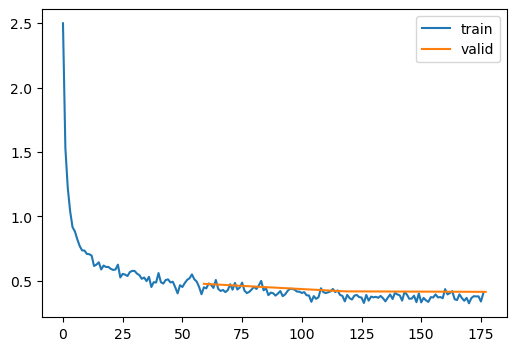

In [8]:
learn.fit(3)

### **A Note on Weight Decay**

Weight decay and L2 regularization are often used interchangeably. The difference is subtle but clear, as this [blog](https://benihime91.github.io/blog/machinelearning/deeplearning/python3.x/tensorflow2.x/2020/10/08/adamW.html) points out.

> The major difference between L2 regularization & weight decay is while the former modifies the gradients to add `lamdba * w` , weight decay does not modify the gradients but instead it subtracts `learning_rate * lamdba * w` from the weights in the update step.

When written in code, the difference becomes clearer still:

`L2 Regularization`
```
weight -= lr * wd * weight
```
`Weight Decay`
```
weight.grad += wd * weight
```


> ...weight decay and L2 regularization may seem the same and it is infact same for vanilla SGD , but as soon as we add momentum, or use a more sophisticated optimizer like Adam, L2 regularization and weight decay become different. 

## **Momentum Revisited**

We will now proceed to add Momentum to our optimizer. But first, let's create some data points and plot them with different momentum values to demonstrate how it works.

In [11]:
# Generating random data
xs = torch.linspace(-4, 4, 100)
ys = 1 - (xs / 3)**2 + torch.randn(100) * 0.1

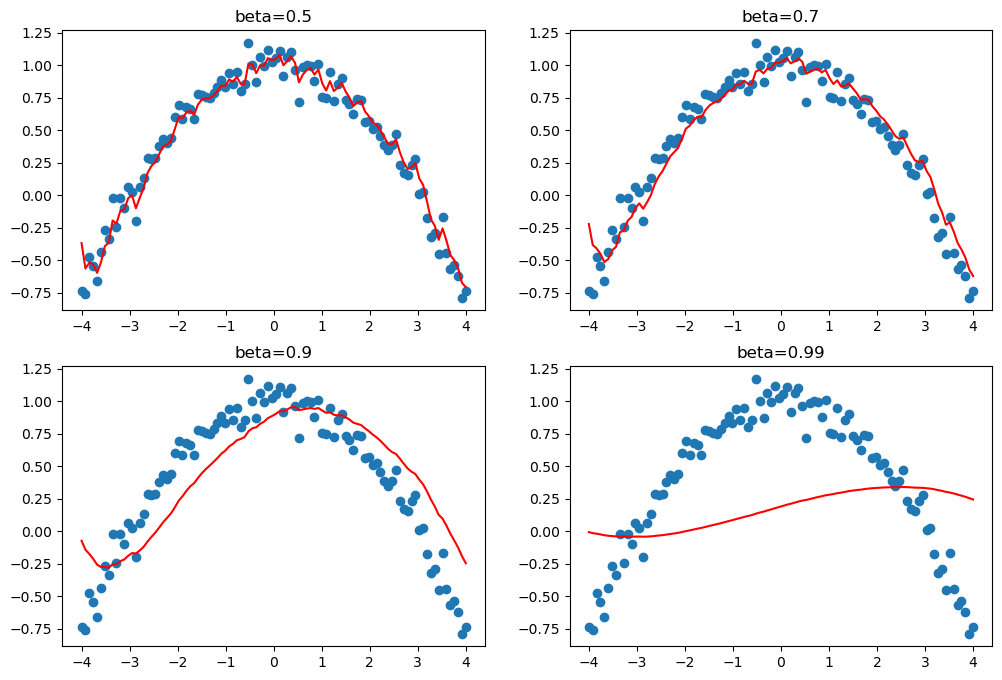

In [12]:
_, axs = plt.subplots(2, 2, figsize=(12, 8))
# Levels of momentum
betas = [0.5, 0.7, 0.9, 0.99]

for beta, ax in zip(betas, axs.flatten()):
    ax.scatter(xs, ys)
    avg, res = 0, []
    for yi in ys:
        # This is effectively doing a LERP
        avg = beta*avg + (1-beta)*yi
        res.append(avg)
    ax.plot(xs, np.array(res), color='red');
    ax.set_title(f'beta={beta}')

In [25]:
class Momentum(SGD):
    def __init__(self, params, lr, wd=0., mom=0.9): # As before, FastAI's momentum is the opposite of PyTorch's implementation
        super().__init__(params, lr=lr, wd=wd)
        self.mom = mom

    def opt_step(self, p):
        # Check for stored values of grad_avg, by creating a new attribute within the opt_step function
        if not hasattr(p, 'grad_avg'): p.grad_avg = torch.zeros_like(p.grad)
        p.grad_avg = p.grad_avg*self.mom + p.grad*(1-self.mom) # MomentumLearner didn't feature the lerp i.e. (1-self.mom)
        # Key difference with SGD.
        p -= self.lr * p.grad_avg        

In [21]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1.5, cbs=cbs, opt_func=Momentum)

accuracy,loss,epoch,train
0.787,0.596,0,train
0.847,0.416,0,eval
0.869,0.359,1,train
0.860,0.372,1,eval
0.885,0.315,2,train
0.875,0.351,2,eval


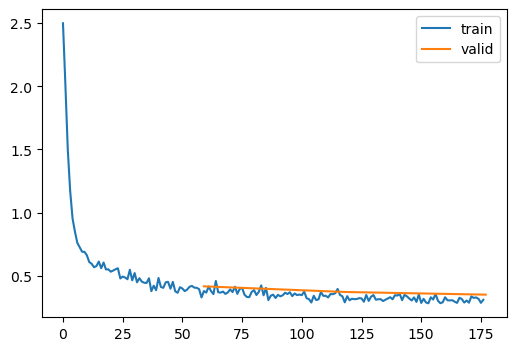

In [22]:
learn.fit(3)

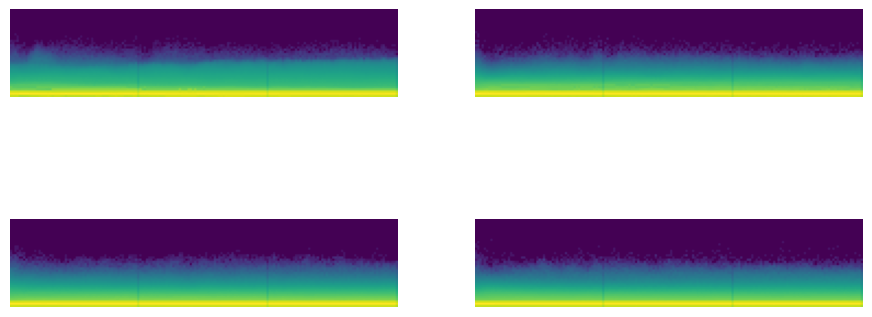

In [23]:
astats.color_dim()

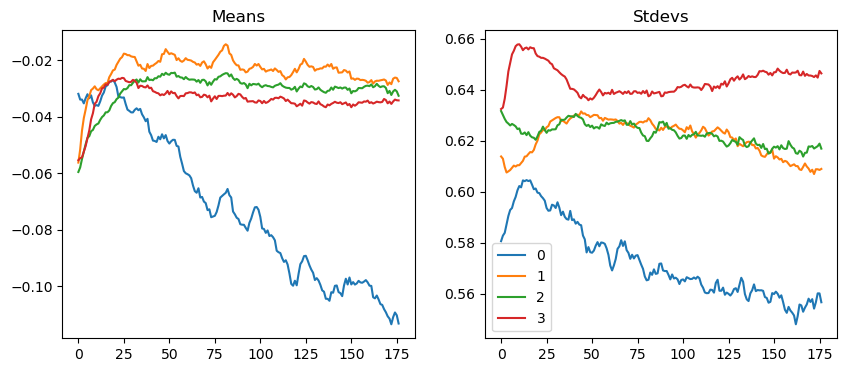

In [24]:
astats.plot_stats()

## **RMS Prop**

RMS Prop was introduced as part of a [Coursera course's lecture slides](http://www.cs.toronto.edu/~hinton/coursera/lecture6/lec6.pdf) by Geoffery Hinton.

A more detailed walkthrough can be found on [Machine Learning Mastery.](https://machinelearningmastery.com/gradient-descent-with-rmsprop-from-scratch/).

Effectively, we will be lerping on `p.grad**2` and will call the momentum multiplier `self.sqr_mom`. Here large `p.grad**2` values indicate a high degree of variance within the gradients. Thus the division will be taken with the square root of the `p.sqr_avg`.

In [26]:
class RMSProp(SGD):
    def __init__(self, params, lr, wd=0., sqr_mom=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.sqr_mom, self.eps = sqr_mom, eps

    def opt_step(self, p):
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = p.grad**2
        p.sqr_avg = p.sqr_avg * self.sqr_mom + p.grad**2 * (1 - self.sqr_mom)
        p -= self.lr * p.grad / (p.sqr_avg.sqrt() + self.eps)

accuracy,loss,epoch,train
0.765,0.665,0,train
0.822,0.482,0,eval
0.848,0.416,1,train
0.845,0.426,1,eval
0.866,0.367,2,train
0.852,0.401,2,eval


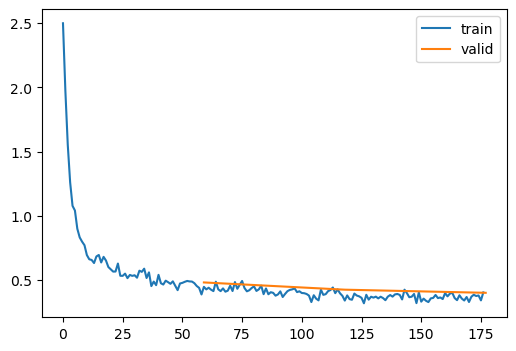

In [27]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=cbs, opt_func=RMSProp)
learn.fit(3)

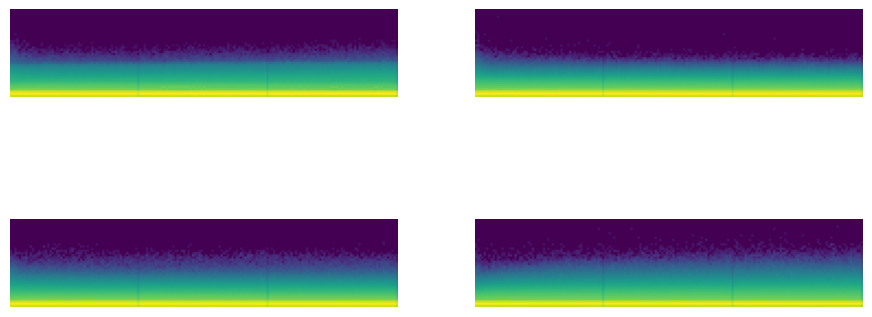

In [28]:
astats.color_dim()

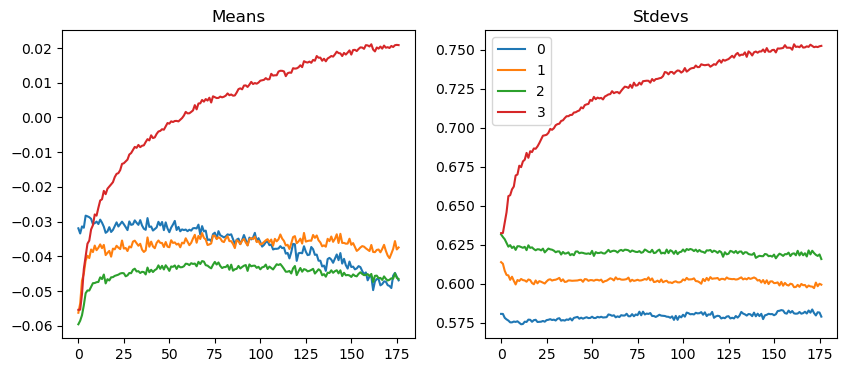

In [29]:
astats.plot_stats()

RMS Prop can be quite handy when use with more complex architectures like EfficientNet, whereas Momentum can be quite aggressive.

## **Adam**

By combining RMSProp and Momentum, we get the popular optimizer `Adam`. The details can be found in the paper ["Adam: A Method for Stochastic Optimization"](https://arxiv.org/abs/1412.6980).

In [32]:
class Adam(SGD):
    # beta1 & beta2 can be called momentum and square momentum
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1, self.beta2, self.eps = beta1, beta2, eps

    def opt_step(self, p):
        # if p doesn't already have these attribs they are initialized to tensors of 0
        # with the same shape as the gradient `p.grad`
        if not hasattr(p, 'avg'):     p.avg = torch.zeros_like(p.grad.data)
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data)
        # Update exponential moving average of the gradient
        p.avg = self.beta1 * p.avg + (1 - self.beta1) * p.grad
        # Correct the bias introduced by initializing `p.avg` to zero
        unbias_avg = p.avg / (1 - (self.beta1**(self.i + 1)))
        # Update exponential moving average of the squared gradient
        p.sqr_avg = self.beta2 * p.sqr_avg + (1 - self.beta2) * (p.grad**2)
        # Correct the bias of the above
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i + 1)))
        p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

accuracy,loss,epoch,train
0.792,0.583,0,train
0.840,0.428,0,eval
0.870,0.359,1,train
0.857,0.381,1,eval
0.886,0.312,2,train
0.874,0.345,2,eval


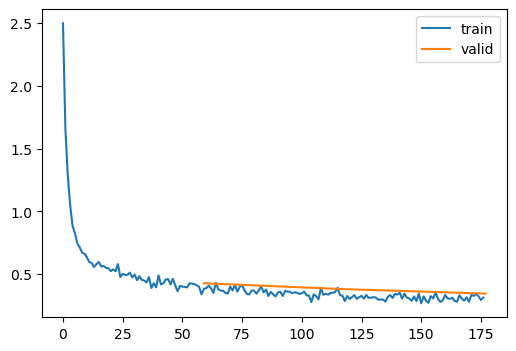

In [33]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=Adam)
learn.fit(3)

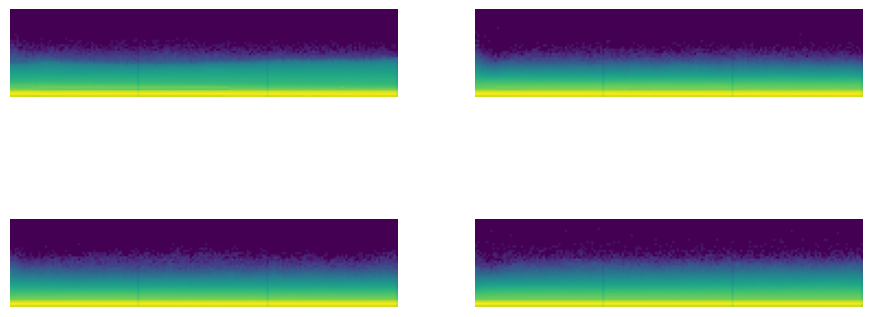

In [34]:
astats.color_dim()

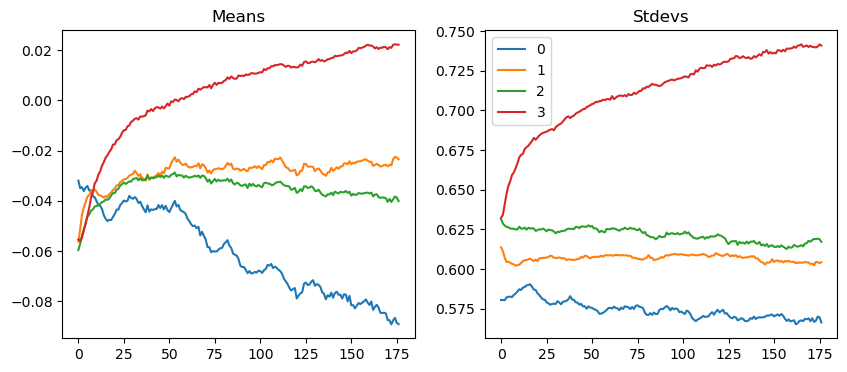

In [35]:
astats.plot_stats()